# Comparison of softmax and micropatch distribution 

# CHECKLIST 
1) [x] Import turf imagery and SfM estimates (and ground truth)
2) [x] Implement pose estimations and 'converged solution' for individual patches
3) [x] Divide each patch into micro patches
4) [x] Calculate error vector for each micropatch
5) [x] Generate mean and covariance data for a set of micropatches
6) [ ] Calculate softmax distbribution for full PATCHES
7) [ ] Plot softmax vs micropatch distribution

Unknowns

$$
\mathbf{x} = [X, Y, Z, \phi, \theta, \psi]^T
$$


Generating SSD values for n micropatches

$$
\mathrm{SSD}_i(\Delta x, \Delta y)
=
\sum_{(p,q)}\sum_{ \in A_g}
\Big[
    I_i(p + \Delta x,\; q + \Delta y)
    - I_s(p, q)
\Big]^2
$$

The correction vector over each micropatch i represented by 

$$
\mathbf{e}_i
=
\begin{bmatrix}
e_x \\
e_y
\end{bmatrix}
=
\arg\min_{\Delta x,\;\Delta y}
\mathrm{SSD}_i(\Delta x,\Delta y)
$$

Across n micropatches 

MEAN

$$
\boldsymbol{\mu}
=
\begin{bmatrix}
\bar e_x \\
\bar e_y
\end{bmatrix}
=
\frac{1}{n}\sum_{i=1}^{n}
\begin{bmatrix}
e_{x,i} \\
e_{y,i}
\end{bmatrix}
$$


VARIANCE 
$$
R_p
=
\begin{bmatrix}
\sigma_x^2 & \sigma_{xy} \\
\sigma_{xy} & \sigma_y^2
\end{bmatrix}
=
\frac{1}{n-1}
\sum_{i=1}^{n}
\Bigg(
\begin{bmatrix}
e_{x,i} \\
e_{y,i}
\end{bmatrix}
-
\begin{bmatrix}
\bar e_x \\
\bar e_y
\end{bmatrix}
\Bigg)
\Bigg(
\begin{bmatrix}
e_{x,i} \\
e_{y,i}
\end{bmatrix}
-
\begin{bmatrix}
\bar e_x \\
\bar e_y
\end{bmatrix}
\Bigg)^{T}
$$



$$
\mathrm{SSD}_n(\Delta x, \Delta y)
=
\sum_{p}\sum_{q \in A_g}
\Big[m \Big]^2
$$


$$
\mathbf{e}_i
=
\begin{bmatrix}
0 \\
0
\end{bmatrix}
$$

In [1]:
import numpy as np 
import cv2
import pickle
from matplotlib.patches import Ellipse
import pandas as pd

from groundNAV_agent import *


# SAVE YOUR WORK
%load_ext autoreload
%autoreload 2
%autosave 180

/home/daniel-choate/miniconda3/envs/py39/lib/python3.9/site-packages/dash/dash.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, parse_version


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


In [2]:
# SfM files 
images_colm = '../TurfData/SfM_soln/images.txt'
cameras_colm = '../TurfData/SfM_soln/cameras.txt'
pts3d_colm = '../TurfData/SfM_soln/points3D_f.txt'

# Local images - folder
# im_local = '../TurfData/local_imgs_10' # With 10 local images 
im_local = '../TurfData/local_imgs_5' # With 5 local images

# Satellite reference image
sat_ref = '../TurfData/TurfSat.jpg'

In [3]:
# Create class 
gnav = gNAV_agent(images_colm, cameras_colm, pts3d_colm, im_local, sat_ref)

### Implement pose estimations and ground truth solutions

In [4]:
# SET REFERENCE FRAME
# Set reference frame - transform to ground-parallel coordinate frame 
tform_ref_frame = gnav.set_ref_frame(gnav.pts_gnd_idx)
tform_ref_frame_pts = gnav.inv_homog_transform(tform_ref_frame)
print("\nReference frame transformation\n", tform_ref_frame_pts)

# Transfer all points to new coordinate system
origin_ref, scene_pts_ref, scene_vec_ref = gnav.unit_vec_tform(gnav.scene_pts, gnav.origin_w, tform_ref_frame_pts)


Reference frame transformation
 [[-1.55069060e-03  9.81197008e-01  1.93002661e-01 -1.21025836e-01]
 [-1.42845166e-01 -1.91240997e-01  9.71093270e-01  1.86102525e+00]
 [ 9.89743833e-01 -2.60636319e-02  1.40455805e-01  7.28134156e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


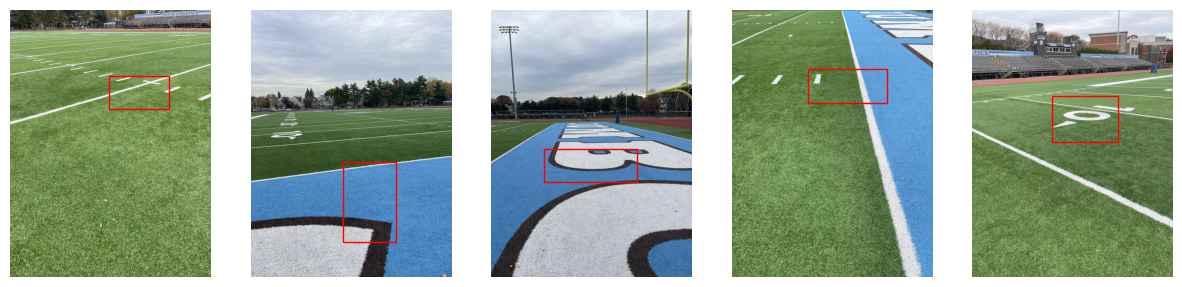

In [5]:
# Import mosaic parameters - arbitrarily obtained, can be modified
mosaic_params = np.load('../TurfData/GP_sections/mosaic_params.npy')
# Grab specified image points from local images 
gnav.grab_image_pts_tot(mosaic_params)

plt.figure(figsize=(15,8))
gnav.plot_gnd_pts()

In [6]:
# Generate projection of image sections 
for i in range(len(gnav.images_dict)):
    # STEP 1: Unit vectors in camera coords 
    pts_vec_c, pts_rgb_gnd = gnav.unit_vec_c(i)
    gnav.im_mosaic[i] = {'rgbc': pts_rgb_gnd}

    # STEP 2: Transformation matrix moves from camera coords to world coords
    id = gnav.im_ids[i]
    homog_w2c, homog_c2w = gnav.get_pose_id(id,i)
    # print('Homogeneous transformation from world to camera \n', homog_c2w)
    # print('\n Homogeneous transformation from camera to world \n', homog_w2c)

    # STEP 3: Transform to world coords
    origin_c, pts_loc_w, pts_vec_w = gnav.unit_vec_tform(pts_vec_c, gnav.origin_w, homog_c2w)
    # print('\n New camera frame origin = ', origin_c)
    
    # STEP 4: Get new points 
    ranges, new_pts_w = gnav.pt_range(pts_vec_w, homog_c2w, origin_c, i)
    # print('\nNew Points \n', new_pts_w)

    # STEP 5: Transfer points to reference frame
    __, new_pts_r, pts_vec_r = gnav.unit_vec_tform(new_pts_w, gnav.origin_w, tform_ref_frame_pts)

    # Convert points to grayscale 
    gray_c = gnav.conv_to_gray(gnav.im_mosaic[i]['rgbc'],i)
    # print(gray_c)

    # Put new points and grayscale colors in image mosaic
    gnav.im_mosaic[i]['pts'] = new_pts_r
    gnav.im_mosaic[i]['color_g'] = gray_c
    
    print("\nDone image ", i)


Done image  0

Done image  1

Done image  2

Done image  3

Done image  4


In [7]:
# Initial guess parameters 
# 5 image solution
scale, yaw, x_g, y_g = 80, np.deg2rad(140), -52, 20
# BEST after CONVERGENCE
scale = 80.14819958
yaw = 2.44777939
x_g = -55.46495001
y_g = 21.62910054

tform_guess = gnav.tform_create(x_g,y_g,0,0,0,yaw)
gnav.best_guess_tform = tform_guess
gnav.best_guess_scale = scale

# Implement
gnav.implement_guess(gnav.best_guess_tform, gnav.best_guess_scale)

In [62]:
# Create visualization
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Image mosaic with reference map (initial guess)")

gnav.mosaic_w_ref_visualization(vis)

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
pci id for fd 81: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


### Divide each patch into micro-patches

- [x] Grab patch from ground image
- [x] Project patch onto satellite image (trapezoid)
- [x] Find bounds of trapezoid
- [x] Divide bounding box into uniform squares
- [x] Check which squares are fully within the trapezoid

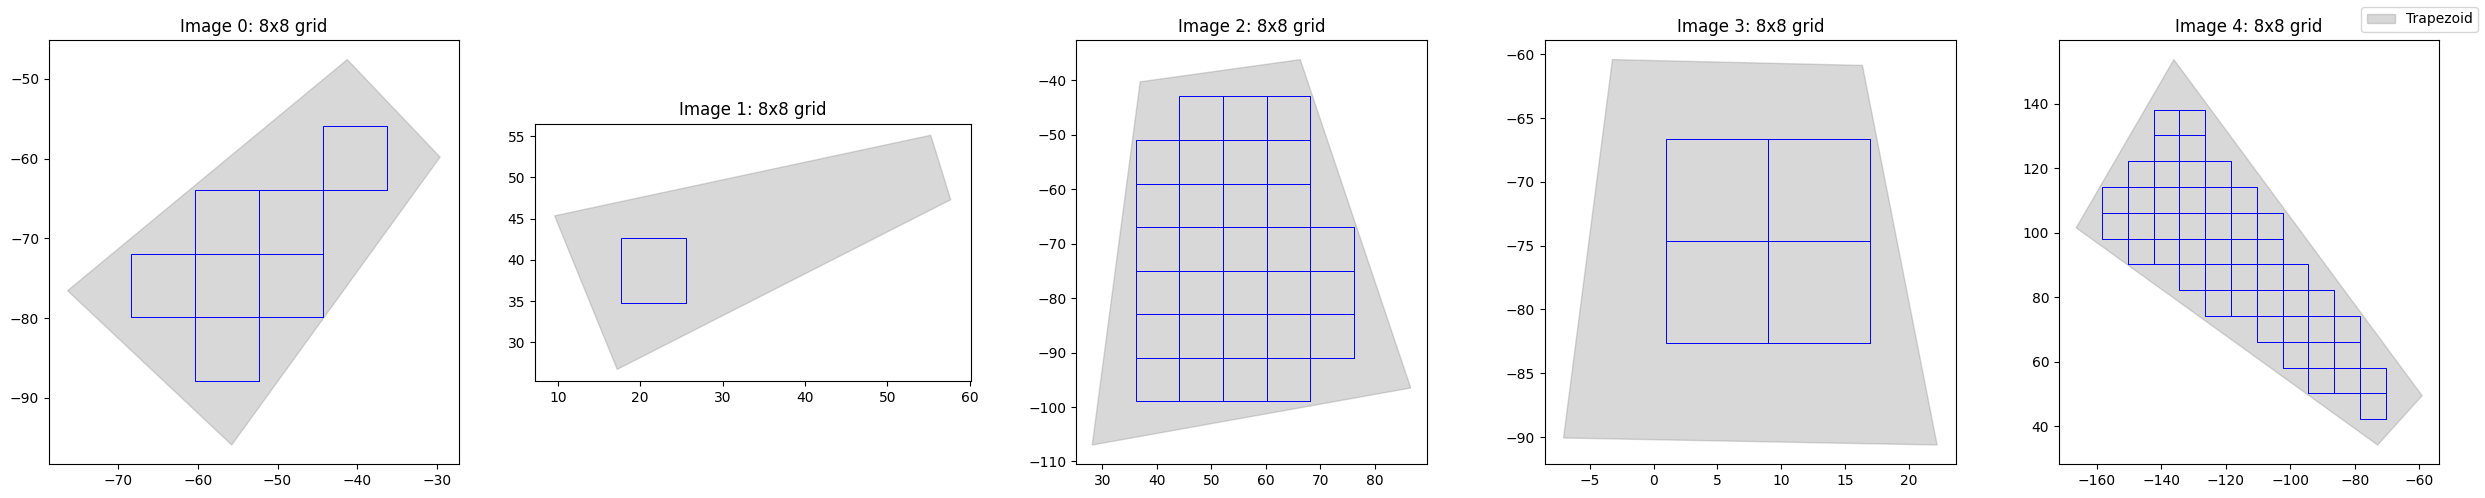

In [9]:
n = 8
micro_ps = gnav.micropatch_division(n)
gnav.micro_ps_local = copy.deepcopy(gnav.micro_ps) # KEEPING ORIGINAL, LOCAL IS WHAT WE EDIT
gnav.plot_traps_w_microps(n)

In [10]:
print([len(micro_ps[i]) for i in range(5)])

[7, 1, 30, 4, 48]


In [11]:
# # Check that the points are at least proper

# # PLOTTING THE NEW SCENE MOSAIC

# # Use open3d to create point cloud visualization 
# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Mosaic scene with satellite reference")

# # Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10)
# # vis.add_geometry(axis_origin)

# # Add image patches
# # for i in range(len(gnav.images_dict)):
# # for i in range(2):
# #     cloud = o3d.geometry.PointCloud()
# #     cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[i]['pts'])
# #     cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[i]['color_g'])
# #     vis.add_geometry(cloud)


# # Create point cloud for image points
# for i in range(len(gnav.images_dict)):
#     for j in range(len(micro_ps[i])):
#         # print(j)
#         cloud_micro = o3d.geometry.PointCloud()
#         cloud_micro.points = o3d.utility.Vector3dVector(micro_ps[i][j]['pts'])
#         # cloud_micro.paint_uniform_color([.75, 0.001*j, 0.002*j])
#         cloud_micro.colors = o3d.utility.Vector3dVector(micro_ps[i][j]['color_g'])
#         vis.add_geometry(cloud_micro)



# # Create point cloud for reference cloud (satellite)
# ref_cloud = o3d.geometry.PointCloud()
# ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
# ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)
# vis.add_geometry(ref_cloud)

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()

### SSD Process:
- [x] Gather satellite points from each individual patch
- [x] Grab nearest neighbors of patch points 
- [x] Gather SSDs for each micropatch
- [x] Calculate minimum for each patch
- [x] Generate vector to minimum location
- [x] Plot vectors across each micropatch

In [12]:
ssds_curr_micro = [{} for _ in range(len(gnav.images_dict))]
gnav.ssds_curr_micro = [{} for _ in range(len(gnav.images_dict))]

In [13]:
# # Loop through images and patches
# n_ssd = 5

# for imnum in range(len(gnav.images_dict)):
#     for mp in range(len(gnav.micro_ps[imnum])):
#         ssds = gnav.ssd_nxn_micro(n_ssd, imnum, mp)
#         gnav.ssds_curr_micro[imnum][mp] = ssds
#     print(f'Done image {imnum}')

In [14]:
# # Save data as pickle 
# fn = 'ssd_test_6x6_5n.pkl'
# with open(fn, 'wb') as f:
#     pickle.dump(gnav.ssds_curr_micro, f)

In [15]:
# Import pickle data structure so we do not have to run again
# Load
with open('ssd_test_8x8_5n.pkl', 'rb') as f:
    ssds_curr_micro_pkl = pickle.load(f)

### Minimum SSD and patch distribution 

In [16]:
# for imnum in range(len(gnav.images_dict)):
#     for mp in range(len(gnav.micro_ps[imnum])):
#         diff = gnav.ssds_curr_micro[imnum][mp] - ssds_curr_micro_pkl[imnum][mp]
#         print("DIFF", diff)

In [17]:
gnav.ssds_curr_micro = ssds_curr_micro_pkl

In [18]:
gnav.distb_vecs = [{} for _ in range(gnav.im_num)]
gnav.distb_pts = [{} for _ in range(gnav.im_num)]
gnav.distb_mean_var = [{} for _ in range(gnav.im_num)]
# print(gnav.distb_vecs)

In [19]:
# Grab correction vectors for each micro-patch
n_ssd = 5
for imnum in range(gnav.im_num):
    cor_vecs, points = gnav.dy_from_ssd_micro(n_ssd, imnum)
    gnav.distb_vecs[imnum] = cor_vecs
    gnav.distb_pts[imnum] = points

Done image 0
Done image 1
Done image 2
Done image 3
Done image 4


In [20]:
# Grab mean and variance for each micropatch 
# Add mean and variance for each set of micropatch corrections 
for imnum in range(gnav.im_num):
    # Grab all micropatch corrections
    cor_vecs = gnav.distb_vecs[imnum]
    # print("Correction vectors:\n", cor_vecs)
    if cor_vecs.shape[0] > 1:
        # Mean and variance
        x_bar = np.mean(cor_vecs[:,0])
        y_bar = np.mean(cor_vecs[:,1])
        gnav.distb_mean_var[imnum]['mean'] = np.array([x_bar, y_bar])
        cov_matrix = np.cov(cor_vecs.T)
        # print("Numpy cov matrix:\n", cov_matrix)
        gnav.distb_mean_var[imnum]['cov'] = cov_matrix
        
    else:
        gnav.distb_mean_var[imnum]['mean'] = cor_vecs[0] if cor_vecs.shape[0] == 1 else np.array([0,0])
        gnav.distb_mean_var[imnum]['cov'] = np.zeros((2,2))
    # print(x_bar, y_bar)
    
print(gnav.distb_mean_var[4])

{'mean': array([1.66666667, 1.70833333]), 'cov': array([[16.09929078, -2.03546099],
       [-2.03546099, 13.06205674]])}


In [21]:
# PLOT 2D Correction vectors on each micropatch
def plot_microps_w_corVecs():
    """ 
    Use matplotlib to plot the patch trapezoids with the grids of the micropatches AND error correction vectors 
    Input: Nada
    Output: Subplot with trapezoids and micropatch grids
    """

    num_imgs = len(gnav.images_dict)
    # fig, axes = plt.subplots(1, num_imgs, figsize=(5*num_imgs, 5))
    fig, axes = plt.subplots(num_imgs, 1, figsize=(10, 20))

    for i in range(num_imgs):
        ax = axes[i] if num_imgs > 1 else axes
        
        # Polygon bound of mosaic points 
        # Get corners
        pts_curr = gnav.im_pts_best_guess[i]['pts']
        corners = gnav.im_pts_2d[i]['corners']
        # Define corner indices 
        idxs = [0, -corners[2], -1, corners[2]-1]
        # Grab corner points
        pts_corners = np.array(pts_curr[idxs])
        # Create polygon 
        poly = Polygon(pts_corners[:,:2])
        # Draw the base trapezoid
        x, y = poly.exterior.xy
        ax.fill(x, y, alpha=0.3, color='gray', label='Trapezoid')

        # Draw micropatches from corners
        for j in range(len(gnav.micro_ps[i])):
            corners = gnav.micro_ps[i][j]['corners']
            if corners is None or len(corners) == 0:
                continue

            # Close the polygon by repeating the first point
            corners_closed = np.vstack([corners, corners[0]])
            xs, ys = corners_closed[:, 0], corners_closed[:, 1]

            ax.plot(xs, ys, color='blue', linewidth=0.7)

        # Draw CORRECTION VECTORS for each micropatch
        # for mp in range(len(gnav.ssds_curr_micro[i])):
        pts_corr = gnav.distb_pts[i]
        mps = len(gnav.ssds_curr_micro[i])
        # Split into base and end points
        base = pts_corr[:mps]
        end = pts_corr[mps:]
    
        # Compute vector components
        u = end[:, 0] - base[:, 0]
        v = end[:, 1] - base[:, 1]
    
        # Plot arrows
        ax.quiver(base[:, 0], base[:, 1], u, v,
                  angles='xy', scale_units='xy', scale=1,
                  color='red', width=0.004, label='Correction Vectors')
    
        # Optionally: mark start and end points
        ax.scatter(base[:, 0], base[:, 1], color='black', s=10, label='Base')
        ax.scatter(end[:, 0], end[:, 1], color='orange', s=10, label='End')
        
        # print(mps)
        # print(pts_corr)
        
        ax.set_aspect('equal')
        ax.set_title(f"Image {i}")

    # Shared legend
    handles, labels = axes[0].get_legend_handles_labels() if num_imgs > 1 else ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()



# PLOT 2D Correction vectors on each micropatch
def plot_microps_w_corVecs_SOFTMAX():
    """ 
    Use matplotlib to plot the patch trapezoids with the grids of the micropatches AND error correction vectors 
    Input: Nada
    Output: Subplot with trapezoids and micropatch grids
    """

    num_imgs = len(gnav.images_dict)
    # fig, axes = plt.subplots(1, num_imgs, figsize=(5*num_imgs, 5))
    fig, axes = plt.subplots(num_imgs, 1, figsize=(10, 20))

    for i in range(num_imgs):
        ax = axes[i] if num_imgs > 1 else axes
        
        # Polygon bound of mosaic points 
        # Get corners
        pts_curr = gnav.im_pts_best_guess[i]['pts']
        corners = gnav.im_pts_2d[i]['corners']
        # Define corner indices 
        idxs = [0, -corners[2], -1, corners[2]-1]
        # Grab corner points
        pts_corners = np.array(pts_curr[idxs])
        # Create polygon 
        poly = Polygon(pts_corners[:,:2])
        # Draw the base trapezoid
        x, y = poly.exterior.xy
        ax.fill(x, y, alpha=0.3, color='gray', label='Trapezoid')

        # Draw micropatches from corners
        for j in range(len(gnav.micro_ps[i])):
            corners = gnav.micro_ps[i][j]['corners']
            if corners is None or len(corners) == 0:
                continue

            # Close the polygon by repeating the first point
            corners_closed = np.vstack([corners, corners[0]])
            xs, ys = corners_closed[:, 0], corners_closed[:, 1]

            ax.plot(xs, ys, color='blue', linewidth=0.7)

        # Draw CORRECTION VECTORS for each micropatch
        # for mp in range(len(gnav.ssds_curr_micro[i])):
        pts_corr = gnav.distb_pts[i]
        mps = len(gnav.ssds_curr_micro[i])
        vecs_sm = np.array([gnav.prob_distb_microp[i][mp]['mu'] for mp in range(len(gnav.prob_distb_microp[i]))])
        vecs_sm = np.hstack([vecs_sm, np.zeros((vecs_sm.shape[0], 1))])
        # print(pts_corr)
        # print(vecs_sm)
        # Split into base and end points
        base = pts_corr[:mps]
        end = pts_corr[:mps] + vecs_sm
    
        # Compute vector components
        u = end[:, 0] - base[:, 0]
        v = end[:, 1] - base[:, 1]
    
        # Plot arrows
        ax.quiver(base[:, 0], base[:, 1], u, v,
                  angles='xy', scale_units='xy', scale=1,
                  color='red', width=0.004, label='Correction Vectors')
    
        # Optionally: mark start and end points
        ax.scatter(base[:, 0], base[:, 1], color='black', s=10, label='Base')
        ax.scatter(end[:, 0], end[:, 1], color='orange', s=10, label='End')
        
        # print(mps)
        # print(pts_corr)
        
        ax.set_aspect('equal')
        ax.set_title(f"Image {i}")

    # Shared legend
    handles, labels = axes[0].get_legend_handles_labels() if num_imgs > 1 else ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()


In [22]:
# Plotting x and y from zero - avg distance from trough - bullet 1
def plot_distb_vecs_BOTH(distb_vecs, distb_mean_var):
    """
    Plots the x and y offset correction vector for each micropatch per image
    Input: nada 
    Output: 5 plots (or # of images) with x and y correction vector points
    """
    num_imgs = gnav.im_num
    fig, axes = plt.subplots(1, num_imgs, figsize=(20, 4 * num_imgs), squeeze=False)
    axes = axes.flatten()

    for i in range(num_imgs):
        ax = axes[i] if num_imgs > 1 else axes

        # grab correction vectors for ORIGINAL
        xs = distb_vecs[i][:,0]
        ys = distb_vecs[i][:,1]
        ax.scatter(xs,ys, s=10)

        # grab correction vectors for NEW 
        xs = [gnav.prob_distb_microp[i][mp]['mu'][0] for mp in range(len(gnav.prob_distb_microp[i]))]
        ys = [gnav.prob_distb_microp[i][mp]['mu'][1] for mp in range(len(gnav.prob_distb_microp[i]))]
        ax.scatter(xs,ys, s=10, c='r')

        # Mean and cov
        # mean = distb_mean_var[i]['mean']
        # cov = distb_mean_var[i]['cov']
        # # Draw ellipse
        # if np.any(cov) and not np.isnan(cov).any():
        #     vals, vecs = np.linalg.eigh(cov)
        #     order = vals.argsort()[::-1]
        #     vals, vecs = vals[order], vecs[:, order]
        #     angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        #     width, height = 2 * np.sqrt(vals)  # 1-sigma ellipse

        #     ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
        #                   color='red', alpha=0.3, lw=2, label='Covariance (1σ)')
        #     ax.add_patch(ell)

        #     # Mark the mean
        #     ax.scatter(*mean, color='red', s=40, marker='x', label='Mean')

        # Styling
        ax.set_title(f"Image {i}: grid = {n}x{n}", fontsize=12)
        ax.set_xlim([-6, 6])
        ax.set_ylim([-6, 6])
        ax.set_xlabel("X Offset")
        ax.set_ylabel("Y Offset")
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, linestyle='--', alpha=0.6)
        # ax.set_title(f"Image {i}")

## Plot micropatches and error correction vectors

In [23]:
# Plot micropatches and error correction vectors
# plot_microps_w_corVecs()

In [24]:
# for i in range(5):
#     print(f'Distribution vectors for image {i}: \n', gnav.distb_vecs[i])

## Error distribution plots 

WHAT ARE WE AFTER 
- Displaying mean and std for micropatch correction vectors
- For each grid (5,6,8,10,12)

PLOT:
1. [x] Plotting x and y from zero - avg distance from trough
2. [x] Mean and std for each patch per grid 

In [25]:
# Plotting x and y from zero - avg distance from trough - bullet 1
def plot_distb_vecs(distb_vecs, distb_mean_var):
    """
    Plots the x and y offset correction vector for each micropatch per image
    Input: nada 
    Output: 5 plots (or # of images) with x and y correction vector points
    """
    num_imgs = gnav.im_num
    fig, axes = plt.subplots(1, num_imgs, figsize=(20, 4 * num_imgs), squeeze=False)
    axes = axes.flatten()

    for i in range(num_imgs):
        ax = axes[i] if num_imgs > 1 else axes

        # grab correction vectors
        xs = distb_vecs[i][:,0]
        ys = distb_vecs[i][:,1]
        ax.scatter(xs,ys, s=10)

        # Mean and cov
        mean = distb_mean_var[i]['mean']
        cov = distb_mean_var[i]['cov']
        # Draw ellipse
        if np.any(cov) and not np.isnan(cov).any():
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            vals, vecs = vals[order], vecs[:, order]
            angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
            width, height = 2 * np.sqrt(vals)  # 1-sigma ellipse

            ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
                          color='red', alpha=0.3, lw=2, label='Covariance (1σ)')
            ax.add_patch(ell)

            # Mark the mean
            ax.scatter(*mean, color='red', s=40, marker='x', label='Mean')

        # Styling
        ax.set_title(f"Image {i}: grid = {n}x{n}", fontsize=12)
        ax.set_xlim([-6, 6])
        ax.set_ylim([-6, 6])
        ax.set_xlabel("X Offset")
        ax.set_ylabel("Y Offset")
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, linestyle='--', alpha=0.6)
        # ax.set_title(f"Image {i}")

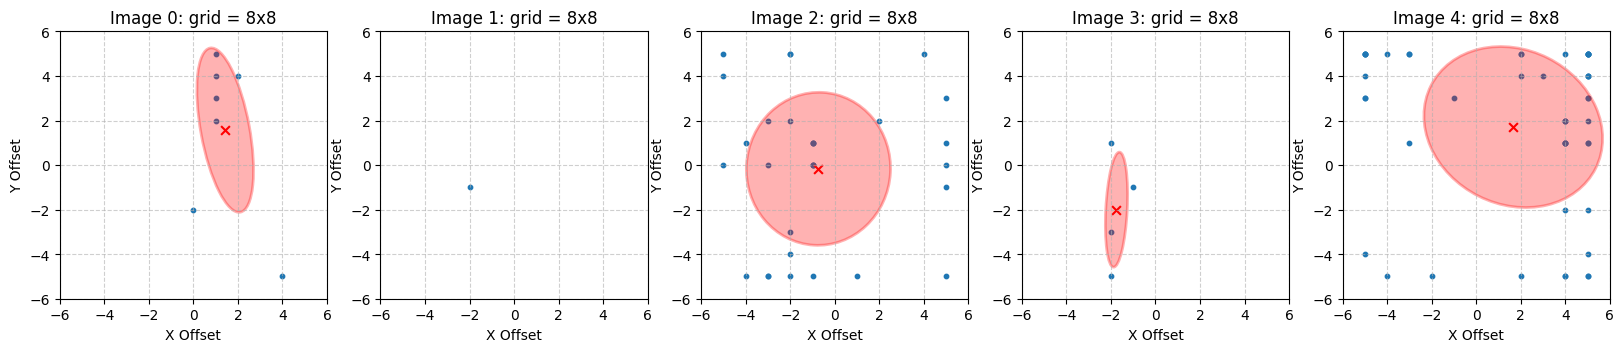

In [26]:
plot_distb_vecs(gnav.distb_vecs, gnav.distb_mean_var)

# Micropatch confidence level 

Determining the confidence directions for each micropatch, to contribute to full patch correction (and covariance)

Utilizing Softmax function (Boltzman distribution)

### Softmax Function for SSD-Based Confidence

Given scores $s_1, s_2, \ldots, s_n$, the softmax function converts them into probabilities:

$$
p_i = \frac{\exp(s_i)}{\sum_j \exp(s_j)}
$$

Softmax: Larger scores receive exponentially more weight.


## Applying Softmax to SSD Values

**lower SSD is better**, we convert SSD into softmax scores by negating them. We also subtract the minimum SSD value for numerical stability:

$$
p(\Delta x, \Delta y)
=
\frac{
    \exp\!\big(
        -\beta \big[
            \mathrm{SSD}(\Delta x, \Delta y)
            - \mathrm{SSD}_{\min}
        \big]
    \big)
}{
    \displaystyle
    \sum_{u=-5}^{5}
    \sum_{v=-5}^{5}
    \exp\!\big(
        -\beta \big[
            \mathrm{SSD}(u, v)
            - \mathrm{SSD}_{\min}
        \big]
    \big)
}
$$

Where:

- **SSD(Δx, Δy)**  
  The SSD value at shift $(\Delta x, \Delta y)$ in the 11×11 grid.

- **SSD_min**  
  The minimum SSD value (stability)

- **β (beta)**  
  A positive scalar controlling sharpness of the distribution.
  - Using 1/std of ssd values
  - Larger β: more peaked probabilities (higher confidence)  
  - Smaller β: flatter probabilities (lower confidence)

## Mean and std

This probabilistic representation allows computation of:

Mean shift vector:

$$
\mu
=
\begin{bmatrix}
\mu_x \\
\mu_y
\end{bmatrix}
=
\sum_{u=-5}^{5}
\sum_{v=-5}^{5}
p(u,v)
\begin{bmatrix}
u \\
v
\end{bmatrix}
$$

Covariance matrix:

$$
\Sigma
=
\sum_{u=-5}^{5}
\sum_{v=-5}^{5}
p(u,v)
\left(
\begin{bmatrix}
u \\
v
\end{bmatrix}
-
\mu
\right)
\left(
\begin{bmatrix}
u \\
v
\end{bmatrix}
-
\mu
\right)^{T}
$$



STEPS:
- [x] Grab ssd values for each FULL PATCH
- [x] Implement softmax function
- [x] Generate new correction and covariance from probability distribution
- [x] Verify test makes sense visually

In [27]:
# softmax implementation 
def prob_distb_softmax(ssds, n):
    """
    Generate a probability distribution for ssd values through softmax function 
    Inputs: ssds (2n+1 x 2n+1), n (shift max)
    Output: probabilities (2n+1 x 2n+1)
    """
    # Calculate beta 
    ssd_std = np.std(ssds)
    beta = 1.0 / (ssd_std + 1e-8)
    # beta *= 5
    # beta=1

    
    # Probability array
    s = np.asarray(ssds, dtype=float)
    min_ssd = s.min()
    # Center
    s_centered = -beta * (s - min_ssd)
    # Shift for numerical stability
    m = s_centered.max()
    exp_shifted = np.exp(s_centered-m)
    probs = exp_shifted / (np.sum(exp_shifted) + 1e-8)
    return probs

def comp_mean_cov(probs, ssds, n):
    """
    Compute mean shift with the given probability vectors
    Input: probabilities, ssds
    Output: mean correction (2,)
    """
    probs = probs.T
    # X and Y grid
    xs = np.arange(-n, n+1)
    X, Y = np.meshgrid(xs, xs, indexing='xy')
    # print(X,Y)
    coords = np.stack([X, Y], axis=-1)
    # print(coords)
    # print(probs[...,None])
    mu = (probs[...,None] * coords).sum(axis=(0,1))  # (2,)
    # print("MU:\n", mu)
    # Difference
    diff = coords - mu[None, None, :]           # (11,11,2)
    diff_outer = diff[..., :, None] * diff[..., None, :]  # (11,11,2,2)
    cov = np.sum(probs[..., None, None] * diff_outer, axis=(0,1))  # (2,2)
    # covariance 2x2
    # cov = np.tensordot(probs, diff, axes=([0,1],[0,1])) 
    # print(cov)
    print("IMAGE:", imnum)
    return mu, cov

In [28]:
print(gnav.distb_mean_var[0])

{'mean': array([1.42857143, 1.57142857]), 'cov': array([[ 1.61904762, -2.28571429],
       [-2.28571429, 13.61904762]])}


#### Full Patch Softmax 

In [29]:
# Through each patch and micro-patch, generate probability distb
gnav.prob_distb_FP = [{} for _ in range(gnav.im_num)]
gnav.ssds_curr_SM = [{} for _ in range(gnav.im_num)]
maxp = 0
for imnum in range(gnav.im_num):
    # Grab ssds - FOR FULL PATCH
    ssds = gnav.ssd_nxn(n_ssd, imnum)
    gnav.ssds_curr_SM[imnum] = ssds

Number of points used for image 0:  (1005,)
Number of points used for image 1:  (645,)
Number of points used for image 2:  (2830,)
Number of points used for image 3:  (731,)
Number of points used for image 4:  (4766,)


In [30]:
for imnum in range(gnav.im_num):
    # Probability distribution
    ssds = gnav.ssds_curr_SM[imnum]
    probs = prob_distb_softmax(ssds, n_ssd)
    # print("Probability MAX:\n", probs.max())
    maxp = max(probs.max(), maxp)
    # Avg correction vector 
    mean_shift, cov = comp_mean_cov(probs, ssds, n_ssd)
    # print(mean_shift)
    # Insert mean and cov 
    gnav.prob_distb_FP[imnum]['mu'] = mean_shift
    gnav.prob_distb_FP[imnum]['cov'] = cov
    gnav.prob_distb_FP[imnum]['probs'] = probs

IMAGE: 0
IMAGE: 1
IMAGE: 2
IMAGE: 3
IMAGE: 4


#### Micropatch softmax 

In [31]:
# # Through each patch and micro-patch, generate probability distb
# gnav.prob_distb_microp = [{} for _ in range(gnav.im_num)]
# maxp = 0
# for imnum in range(gnav.im_num):
#     for mp in range(len(gnav.ssds_curr_micro[imnum])):
#         # Grab ssds
#         ssds = gnav.ssds_curr_micro[imnum][mp]
#         # Probability distribution
#         probs = prob_distb_softmax(ssds, n_ssd)
#         # print("Probability MAX:\n", probs.max())
#         maxp = max(probs.max(), maxp)
#         # Avg correction vector 
#         mean_shift, cov = comp_mean_cov(probs, ssds, n_ssd)
#         # print(mean_shift)
#         # Make sure dict exists for each mp
#         gnav.prob_distb_microp[imnum].setdefault(mp, {})
#         # INsert mean and cov
#         gnav.prob_distb_microp[imnum][mp]['mu'] = mean_shift
#         gnav.prob_distb_microp[imnum][mp]['cov'] = cov

In [32]:
# Plotting x and y from zero - avg distance from trough - bullet 1
def plot_softmax_microp_COMP(distb_vecs, distb_mean_var_SM, distb_mean_var):
    """
    Plots the x and y offset correction vector for each micropatch per image
    Input: nada 
    Output: 5 plots (or # of images) with x and y correction vector points
    """
    num_imgs = gnav.im_num
    fig, axes = plt.subplots(1, num_imgs, figsize=(20, 4 * num_imgs), squeeze=False)
    axes = axes.flatten()

    for i in range(num_imgs):
        ax = axes[i] if num_imgs > 1 else axes

        # grab correction vectors
        xs = distb_vecs[i][:,0]
        ys = distb_vecs[i][:,1]
        ax.scatter(xs,ys, s=10)

        # Mean and cov
        mean = distb_mean_var_SM[i]['mu']
        cov = distb_mean_var_SM[i]['cov']
        # Draw ellipse
        if np.any(cov) and not np.isnan(cov).any():
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            vals, vecs = vals[order], vecs[:, order]
            angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
            width, height = 2 * np.sqrt(vals)  # 1-sigma ellipse

            ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
                          color='red', alpha=0.3, lw=2, label='Covariance (1σ)')
            ax.add_patch(ell)

            # Mark the mean
            ax.scatter(*mean, color='red', s=40, marker='x', label='Mean')

        # Mean and cov
        mean = distb_mean_var[i]['mean']
        cov = distb_mean_var[i]['cov']
        # Draw ellipse
        if np.any(cov) and not np.isnan(cov).any():
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            vals, vecs = vals[order], vecs[:, order]
            angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
            width, height = 2 * np.sqrt(vals)  # 1-sigma ellipse

            ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
                          color='blue', alpha=0.3, lw=2, label='Covariance (1σ)')
            ax.add_patch(ell)

            # Mark the mean
            ax.scatter(*mean, color='blue', s=40, marker='x', label='Mean')

        # Styling
        ax.set_title(f"Image {i}: grid = {n}x{n}", fontsize=12)
        ax.set_xlim([-6, 6])
        ax.set_ylim([-6, 6])
        ax.set_xlabel("X Offset")
        ax.set_ylabel("Y Offset")
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, linestyle='--', alpha=0.6)
        # ax.set_title(f"Image {i}")

In [33]:
def ssd_surface_plots(ssds, imnum, n):
    """
    Surface plot visualizations for SSD confidence level
    Inputs: Figure, Images to display (1-10 meaining all ten images)
    Output: Figure(s) (depending on number of images)
    """

    # X coords:
    x = np.linspace(-n,n, 2*n+1)
    y = np.linspace(-n,n, 2*n+1)
    Y, X = np.meshgrid(x,y)

    idrow, idcol = np.unravel_index(np.argmin(ssds), ssds.shape)
    shiftx_min = idrow - n
    shifty_min = idcol - n
    print(f"BEST SHIFT for image {imnum}:", shiftx_min, shifty_min)
    # print("BEST SSD =", ssds[idrow, idcol])

    # Plot SSD as a surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Surface plot
    surf = ax.plot_surface(X, Y, ssds, cmap='viridis', edgecolor='none')

    # Highlight minimum SSD point
    ax.scatter(shiftx_min, shifty_min, ssds[idrow, idcol], color='red', s=50, label='Min SSD')

    # Set axis limits
    ax.set_xlim([-n, n])
    ax.set_ylim([-n, n])
    ax.set_zlim([np.min(ssds), np.max(ssds)])

    # Set ticks at every 1 unit
    ax.set_xticks(np.arange(-n, n+1, 5))
    ax.set_yticks(np.arange(-n, n+1, 5))
    ax.set_zticks([])

    # Labels and title
    ax.set_xlabel('X Shift (pixels)')
    ax.set_ylabel('Y Shift (pixels)')
    # ax.set_zlabel('SSD Value')
    ax.set_title(f'SSD Surface Plot: Image {imnum}')
    ax.legend()
    ax.view_init(elev=90, azim=-90)
    # Color bar for the surface
    # fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='SSD Value')

    plt.show()

In [59]:
# Plotting x and y from zero - avg distance from trough - bullet 1
def plot_softmax_and_confdir(distb_vecs, distb_mean_var_SM, elong_ims):
    """
    Plots the x and y offset correction vector for each micropatch per image
    Input: nada 
    Output: 5 plots (or # of images) with x and y correction vector points, distribution from softmax, and confidence direction 
    """
    num_imgs = gnav.im_num
    fig, axes = plt.subplots(1, num_imgs, figsize=(20, 4 * num_imgs), squeeze=False)
    axes = axes.flatten()
    imss = 0

    for i in range(num_imgs):
        ax = axes[i] if num_imgs > 1 else axes

        # grab correction vectors
        xs = distb_vecs[i][:,0]
        ys = distb_vecs[i][:,1]
        ax.scatter(xs,ys, s=10)

        # Mean and cov
        mean = distb_mean_var_SM[i]['mu']
        cov = distb_mean_var_SM[i]['cov']
        # Draw ellipse
        if np.any(cov) and not np.isnan(cov).any():
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            vals, vecs = vals[order], vecs[:, order]
            angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
            width, height = 2 * np.sqrt(vals)  # 1-sigma ellipse

            ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
                          color='red', alpha=0.3, lw=2, label='Covariance (1σ)')
            ax.add_patch(ell)

            # Mark the mean
            ax.scatter(*mean, color='red', s=40, marker='x', label='Mean')

        # Perpendicular DIRECTION 
        # if i in elong_ims:
        if any((not isinstance(e, np.ndarray) and i == e) or (isinstance(e, np.ndarray) and i in e) for e in elong_ims):
            v_perp = elong_ims[imss*2+1]
            ax.quiver(mean[0], mean[1], v_perp[0], v_perp[1],
                  angles='xy', scale_units='xy', scale=.5,
                  color='red', width=0.008, label='Correction Vectors')
            imss += 1
            
            

        # Styling
        ax.set_title(f"Image {i}: grid = {n}x{n}", fontsize=12)
        ax.set_xlim([-6, 6])
        ax.set_ylim([-6, 6])
        ax.set_xlabel("X Offset")
        ax.set_ylabel("Y Offset")
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, linestyle='--', alpha=0.6)
        # ax.set_title(f"Image {i}")

### Plot ORIGINAL micropatch distribution vecs vs. softmax for full image patches 

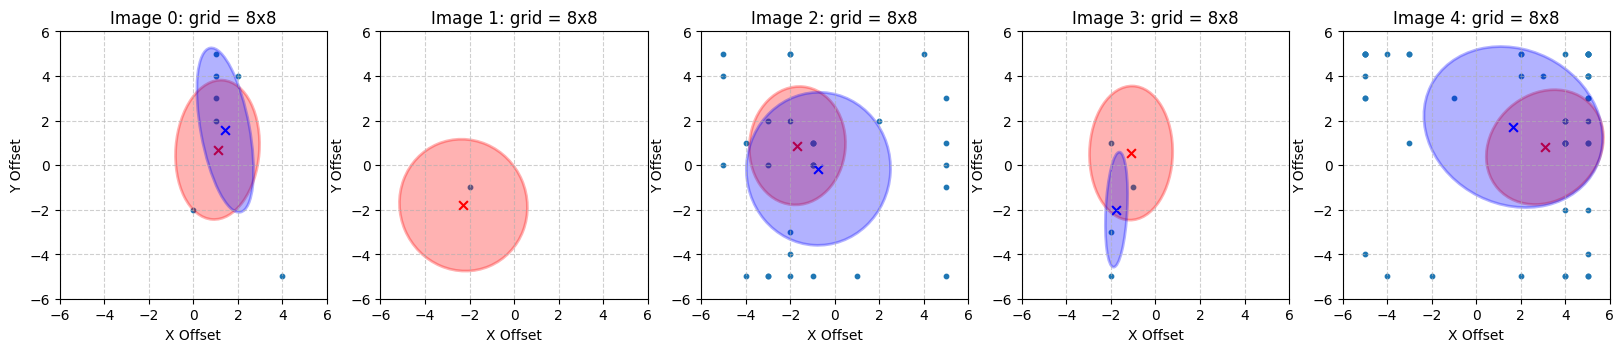

In [37]:
plot_softmax_microp_COMP(gnav.distb_vecs, gnav.prob_distb_FP, gnav.distb_mean_var)

In [38]:
for i in range(gnav.im_num):
    print("MEAN:", gnav.prob_distb_FP[i]['mu'])

MEAN: [1.08383095 0.68665219]
MEAN: [-2.2747052  -1.79756092]
MEAN: [-1.67770403  0.87190089]
MEAN: [-1.09492447  0.54099124]
MEAN: [3.08554245 0.80675422]


In [41]:
# Plot each surface plot 
# %matplotlib qt
# for imnum in range(gnav.im_num):
    # ssd_surface_plots(gnav.ssds_curr_SM[imnum], imnum, n_ssd)
    # ssd_surface_plots(gnav.prob_distb_FP[imnum]['probs'], imnum, n_ssd) # Swap for probabilities?

# Exclusion directions using 2nd Order Moment
- Aiming to turn an SSD into a second order moment
- Utilize the mean and covariance from softmax

STEPS: 
- [ ] Set threshold equal to 2nd order moment of rod
- [ ] Highlight exclusion directions
- [ ] Plot exclusion directions for each micropatch
- [ ] Generate covariance for each micropatch (n covs)
- [ ] Generate an extra covariance for each single-confidence MP (n + x)

In [50]:
for imnum in range(5):
    print(gnav.prob_distb_FP[imnum]['cov'])

[[3.56180259 0.48476352]
 [0.48476352 9.78992856]]
[[ 8.25545276 -0.26472851]
 [-0.26472851  8.76381129]]
[[4.66332082 0.2389683 ]
 [0.2389683  7.0583991 ]]
[[3.48924386 0.12909706]
 [0.12909706 9.06222511]]
[[6.91622871 1.12777674]
 [1.12777674 6.64441756]]


In [51]:
# Eigenvalues and vectors 
# Elongation threshold 
# SET NEW ELONG THRESH TO 1/12 ML ^2
L = 2*n_ssd
T = (1/12) * (L**2)
print(T)

# elong_thresh = 2
ims_elong = []
num_elong = 0
for imnum in range(gnav.im_num):
    cov = gnav.prob_distb_FP[imnum]['cov']
    eigvals, eigvecs = np.linalg.eigh(cov)
    print('\nEigenvalues:\n', eigvals)
    print('Eigenvectors:\n', eigvecs)
    idx = np.argsort(eigvals)
    # print("Indices", idx)
    lam_small = eigvals[idx[0]]
    lam_large = eigvals[idx[-1]]
    # print("Small and large eigenval:", lam_small, lam_large)
    
    v_small = eigvecs[:, idx[0]]   # stable direction
    v_large = eigvecs[:, idx[-1]]  # unstable direction
    # print("Stable:\n", v_small)
    # print("Unstable:\n", v_large)

    # Check large eigenvalue
    if lam_large > T:
        print(f'\nImage {imnum} is ELONGATED')
        ims_elong.append(imnum)
        num_elong += 1
        # ANGLE
        angle_r = np.arctan2(v_large[1], v_large[0])
        angle_deg = np.degrees(angle_r)
        print("ANGLE:", angle_deg)
        if angle_deg > 90:
            angle_deg_half = angle_deg - 180
            v_large = -v_large
        elif angle_deg <= -90:
            angle_deg_half = angle_deg + 180
            v_large = -v_large
        else: 
            angle_deg_half = angle_deg
        v_perp = np.array([v_large[1], -v_large[0]])
        v_perp = v_perp / (np.linalg.norm(v_perp) + 1e-20)
        print("V perpendicular", v_perp)
        ims_elong.append(v_perp)

    
    # print(f'Done image {imnum}\n')

8.333333333333332

Eigenvalues:
 [3.52429709 9.82743406]
Eigenvectors:
 [[-0.99702042  0.07713814]
 [ 0.07713814  0.99702042]]

Image 0 is ELONGATED
ANGLE: 85.57591553945171
V perpendicular [ 0.99702042 -0.07713814]

Eigenvalues:
 [8.142633   8.87663105]
Eigenvectors:
 [[-0.9199425  -0.39205331]
 [-0.39205331  0.9199425 ]]

Image 1 is ELONGATED
ANGLE: 113.08232294852674
V perpendicular [-0.9199425  -0.39205331]

Eigenvalues:
 [4.63971057 7.08200936]
Eigenvectors:
 [[-0.99515465  0.09832205]
 [ 0.09832205  0.99515465]]

Eigenvalues:
 [3.48625496 9.06521401]
Eigenvectors:
 [[-0.99973209  0.02314619]
 [ 0.02314619  0.99973209]]

Image 3 is ELONGATED
ANGLE: 88.67370244023903
V perpendicular [ 0.99973209 -0.02314619]

Eigenvalues:
 [5.64438709 7.91625917]
Eigenvectors:
 [[ 0.6634599  -0.74821184]
 [-0.74821184 -0.6634599 ]]


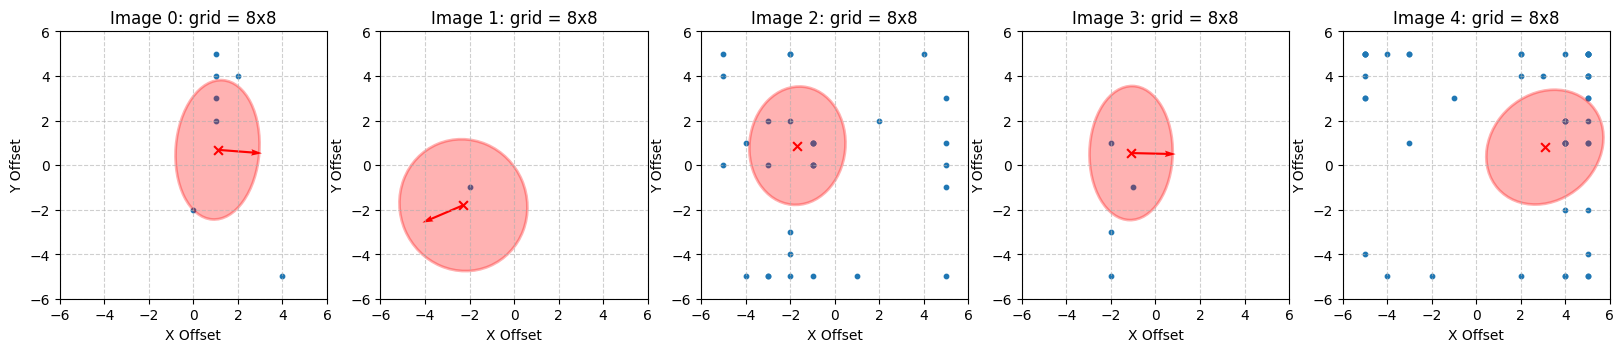

In [60]:
plot_softmax_and_confdir(gnav.distb_vecs, gnav.prob_distb_FP, ims_elong)

In [46]:
print(ims_elong)

[0, array([ 0.99702042, -0.07713814]), 1, array([-0.9199425 , -0.39205331]), 3, array([ 0.99973209, -0.02314619])]


In [47]:
# Direction of uncertainty
for i in range(num_elong):
    imnum = ims_elong[i*2]
    print(imnum)
    v_perp = ims_elong[i*2 + 1]
    print(v_perp)

0
[ 0.99702042 -0.07713814]
1
[-0.9199425  -0.39205331]
3
[ 0.99973209 -0.02314619]
